# Un premier graphe de compositeurs

In [7]:
from bs4 import BeautifulSoup
import requests
import re
import networkx as nx
import spacy
import time
from ipysigma import Sigma

## Variables globales

In [8]:
#Dictionnaire des propriétés souhaitées
dico_props = {"pays" : "P27",
              "nom" : "P735",
              "prenom" : "P734",
              "date de naissance" : "P569",
              "genre" : "P136",
              "influences" : "P737",
              "oeuvres":"P800",
              "religion" : "P140",
              "étudiant de" : "P1066",
              "professeur de": "P802",
              "écoles" : "P69",
              "domaines" : "P101",
              "institut" : "P108",
              "début de carrière" : "P2031",
              "langues" : "P1412",
              "lieux de vie" : "P551",
              "mouvement" : "P135",
              "métiers" : "P106"}

In [9]:
def verbose(message,verb):
    if verb:
        print(message)

In [39]:
def find_id(name):
    """Récupère l'id d'un compositeur à partir de son nom"""
    url = f"https://www.wikidata.org/w/index.php?search={name[0]}+{name[1]}&title=Special%3ASearch&ns0=1&ns120=1"
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    try :
        bloc = soup.find("div", class_ = "mw-search-result-heading")
        group = bloc.find("a")
        if group is None:
            return None
        else:
            return group["href"][6:]
    except:
        print(f"Erreur sur le nom {name[0]} {name[1]}")
        return None

In [11]:
find_id(("Johann-Sebastian","Bach"))

'Q1339'

## Récupération des noms depuis Classic Cat

In [12]:
url = requests.get("https://www.classiccat.net/composers.php")
page = BeautifulSoup(url.content, "html.parser")
li_compo = page.find_all("a", href = True)
compos = []
for lien in li_compo:
    text = lien.get_text()
    if "," in text:
        if len(compos)>0:
            if text[0] < compos[-1][0]:
                break
        compos.append(text)


In [13]:
composers = [(compo.split(",")[1],compo.split(",")[0])  for compo in compos]

## Complétion des données à partir de l'endpoint Sparqle de Wikidata

In [14]:
def actualise_prop(dico,prop,nameprop,id):
    """Actualise le dictionnaire avec la propriété prop"""
    sparql_endpoint = "https://query.wikidata.org/sparql"
    query = f"""
    SELECT ?prop ?propLabel WHERE {{
        wd:{id} wdt:{prop} ?prop.
        SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],fr". }}
    }}
    """
    response = requests.get(sparql_endpoint, params={'query': query, 'format': 'json'})
    time.sleep(0.05)
    li_rep = []
    if response.status_code == 200:
        data = response.json()
        for item in data['results']['bindings']:
            li_rep.append((item['prop']['value'][31:],item['propLabel']['value']))
        dico[nameprop] = li_rep
    else:
        dico[nameprop] = None
        print("Erreur lors de la requête SPARQL:", response.status_code)

In [15]:
name = ("Johann-Sebastian","Bach")
id = find_id(name)
dico = {}
actualise_prop(dico,'P27','pays',id)
dico

{'pays': [('Q12548', 'Saint-Empire romain germanique'),
  ('Q696651', 'duché de Saxe-Eisenach')]}

In [16]:
def create_profile(name,dico_props):
    """Créé le profil d'un compositeur à partir des propriétés voulues et de son nom"""
    dico = {"prénom" : name[0], "nom" : name[1]}
    id = find_id(name)
    dico["id"] = id
    if id is None:
        print("Erreur, aucun dictonnaire renvoyé")
    for nom,prop in dico_props.items():
        actualise_prop(dico, prop, nom, id)
    return dico

In [17]:
create_profile(("Johann-Sebastian","Bach"),dico_props)

Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429


{'prénom': 'Johann-Sebastian',
 'nom': [('Q4844560', 'Sebastian'), ('Q11122389', 'Johann')],
 'id': 'Q1339',
 'pays': [('Q12548', 'Saint-Empire romain germanique'),
  ('Q696651', 'duché de Saxe-Eisenach')],
 'prenom': [('Q1409748', 'Bach')],
 'date de naissance': [('', '1685-03-31T00:00:00Z')],
 'genre': [('Q8361', 'musique baroque')],
 'influences': [('Q1340', 'Antonio Vivaldi'),
  ('Q76485', 'Johann Pachelbel'),
  ('Q508635', 'Johann Georg Pisendel')],
 'oeuvres': [('Q75464', 'Sonates et partitas pour violon seul'),
  ('Q208224', 'concertos brandebourgeois'),
  ('Q211971', 'Le Clavier bien tempéré'),
  ('Q213728', 'Variations Goldberg'),
  ('Q310549', 'Messe en si mineur'),
  ('Q379111', 'Passion selon Saint Matthieu'),
  ('Q392734', 'Toccata et fugue en ré mineur'),
  ('Q465878', "L'Art de la fugue"),
  ('Q642010', 'Oratorio de Noël'),
  ('Q693675', "L'Offrande musicale"),
  ('Q756843', 'Suites pour violoncelle seul'),
  ('Q865333', 'Passion selon saint Jean'),
  ('Q892166', 'Jesu, 

In [18]:
def create_profile_id(id,dico_props):
    """Créé le profil d'un compositeur à partir des propriétés voulues et de son id"""
    dico = {"id" : id}
    if id is None:
        print("Erreur, aucun dictonnaire renvoyé")
    for nom,prop in dico_props.items():
        actualise_prop(dico, prop, nom, id)
    return dico

In [19]:
create_profile_id("Q38193",dico_props)

Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429


{'id': 'Q38193',
 'pays': None,
 'nom': None,
 'prenom': None,
 'date de naissance': None,
 'genre': None,
 'influences': [('Q859', 'Platon'),
  ('Q5879', 'Johann Wolfgang von Goethe'),
  ('Q9312', 'Emmanuel Kant'),
  ('Q9353', 'John Locke'),
  ('Q35802', 'Baruch Spinoza'),
  ('Q37160', 'David Hume')],
 'oeuvres': None,
 'religion': None,
 'étudiant de': None,
 'professeur de': None,
 'écoles': None,
 'domaines': [('Q9418', 'psychologie'),
  ('Q9465', 'éthique'),
  ('Q27654', 'histoire de la philosophie'),
  ('Q35277', 'métaphysique'),
  ('Q35986', 'esthétique')],
 'institut': None,
 'début de carrière': None,
 'langues': None,
 'lieux de vie': None,
 'mouvement': None,
 'métiers': [('Q36180', 'écrivain ou écrivaine'),
  ('Q333634', 'traducteur ou traductrice'),
  ('Q1622272', "professeur ou professeure d'université"),
  ('Q4964182', 'philosophe'),
  ('Q14915627', 'musicologue')]}

## Complétion plus rapide à l'aide de l'API Wikipedia

In [36]:
def find_all_properties(entity_id,dico_props = None,lg = "fr"):
    url = f"https://www.wikidata.org/w/api.php?action=wbgetentities&format=json&ids={entity_id}"
    response = requests.get(url)
    properties = {"id" : entity_id}
    if response.status_code == 200:
        data = response.json()
        data2 = data['entities'][entity_id]
        if 'labels' in data2 and lg in data2['labels']:
            name = data2['labels'][lg]['value']
        elif 'labels' in data2 and 'en' in data2['labels']:
            name = data2['labels']['en']['value']
        else:
            name = entity_id
        properties["nom"] = name
        if 'descriptions' in data2 and lg in data2['descriptions']:
            desc = data2['descriptions'][lg]['value']
        elif 'descriptions' in data2 and 'en' in data2['descriptions']:
            desc = data2['descriptions']['en']['value']
        else:
            desc = entity_id
        properties["description"] = desc
        claims = data['entities'][entity_id]['claims']
        for prop in claims:
            if prop.startswith("P"):
                if dico_props is None or prop in dico_props.values():
                    if len(claims[prop]) > 0:
                        properties[prop] = []
                        for item in claims[prop]:
                            if 'mainsnak' in item and 'datavalue' in item['mainsnak']:
                                value = item['mainsnak']['datavalue']
                                if value['type'] == 'wikibase-entityid':
                                    properties[prop].append(value['value']['id'])
                                elif value['type'] == 'string':
                                    properties[prop].append(value['value'])
                                elif value['type'] == 'time':
                                    properties[prop].append(value['value']['time'])
                                elif value['type'] == 'quantity':
                                    properties[prop].append(value['value']['amount'])
                                elif value['type'] == 'globe-coordinate':
                                    properties[prop].append((value['value']['latitude'], value['value']['longitude']))
                                else:
                                    properties[prop].append(value['value'])
        if dico_props is not None:
            proprietes = {"id" : entity_id, "nom complet" : name, "description" : desc}
            for name, prop in dico_props.items():
                if prop in properties:
                    proprietes[name] = properties[prop]
            return proprietes
        return properties
    else:
        print(f"Erreur lors de la récupération des propriétés : {response.status_code}")
        return None

In [28]:
dico = find_all_properties(find_id(("Richard","Wagner")), dico_props=dico_props)
dico

{'id': 'Q1511',
 'nom complet': 'Richard Wagner',
 'description': "compositeur, directeur de théâtre, écrivain, chef d'orchestre et polémiste allemand de la période romantique",
 'pays': ['Q153015', 'Q183', 'Q39', 'Q38', 'Q40'],
 'nom': ['Q1249148', 'Q11027623'],
 'prenom': ['Q2539239'],
 'date de naissance': ['+1813-05-22T00:00:00Z', '+1813-00-00T00:00:00Z'],
 'genre': ['Q1344', 'Q2142754', 'Q9730'],
 'influences': ['Q38193'],
 'oeuvres': ['Q114640', 'Q1324254', 'Q560619', 'Q327717', 'Q23085', 'Q190237'],
 'religion': ['Q75809'],
 'étudiant de': ['Q65815'],
 'professeur de': ['Q594113'],
 'écoles': ['Q154804', 'Q1526368', 'Q699668'],
 'domaines': ['Q1344', 'Q279272'],
 'institut': ['Q686522'],
 'début de carrière': ['+1832-00-00T00:00:00Z'],
 'langues': ['Q188'],
 'métiers': ['Q36834',
  'Q8178443',
  'Q158852',
  'Q11774202',
  'Q3387717',
  'Q18814623',
  'Q49757',
  'Q486748',
  'Q1350157',
  'Q18939491',
  'Q36180']}

## Génération du graphe d'influences

Premiers constats : la relation d'influence est trop faible, et subitement très forte lorsqu'il s'agit de philosophes (cf. le graphe de Wagner qui est très encombré du fait de son influence par Schopenhauer).

In [22]:
def generate_color_palette(N):
    """
    Génère une palette de N couleurs en format hexadécimal.

    :param N: Nombre de couleurs à générer
    :return: Liste de couleurs en format hexadécimal
    """
    import colorsys

    # Liste pour stocker les couleurs
    colors = []

    for i in range(N):
        # Calculer la teinte (hue) en fonction de l'index
        hue = i / N
        # Convertir HSV à RGB
        rgb = colorsys.hsv_to_rgb(hue, 1.0, 1.0)
        # Convertir RGB à hexadécimal
        hex_color = '#{:02x}{:02x}{:02x}'.format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))
        colors.append(hex_color)

    return colors

In [23]:
def graph_influence(id_composer,n_max_iter=2, verb = False, lg = "fr"):
    colors  = generate_color_palette(n_max_iter+1)
    G = nx.DiGraph()
    properties = find_all_properties(id_composer, dico_props=dico_props)
    G.add_node(id_composer, **properties)
    G.nodes[id_composer]["color"] = colors[0]
    set_actuel = {id_composer}
    visites = {id_composer: properties}
    for i in range(n_max_iter):
        set_suivant = set()
        verbose(f"Compositeurs à traiter à l'étape {i}/{n_max_iter} : {set_actuel}",verb)
        for id_influ in set_actuel:
            verbose(f"Etude de {id_influ}",verb)
            if visites[id_influ] is not None and "influences" in visites[id_influ].keys():
                influences = visites[id_influ]["influences"]
                verbose(f"Les voisins de {id_influ} : {influences}",verb)
                if influences is not None:
                    for id_suivant in influences:
                        if id_suivant not in visites.keys():
                            verbose(f"Ajout de {id_suivant} dans le graphe",verb)
                            dico = find_all_properties(id_suivant, dico_props=dico_props)
                            G.add_node(id_suivant, **dico)
                            visites[id_suivant] = dico
                            G.nodes[id_suivant]["color"] = colors[i+1]
                        else:
                            verbose(print(f"{id_suivant} déjà présent dans le graphe",verb))
                        G.add_edge(id_influ, id_suivant)
                        set_suivant.add(id_suivant)
        set_actuel = set_suivant.copy()
    for node in G.nodes():
        if node in visites.keys():
            G.nodes[node].update(visites[node])
        else:
            print("Erreur !")
    return G

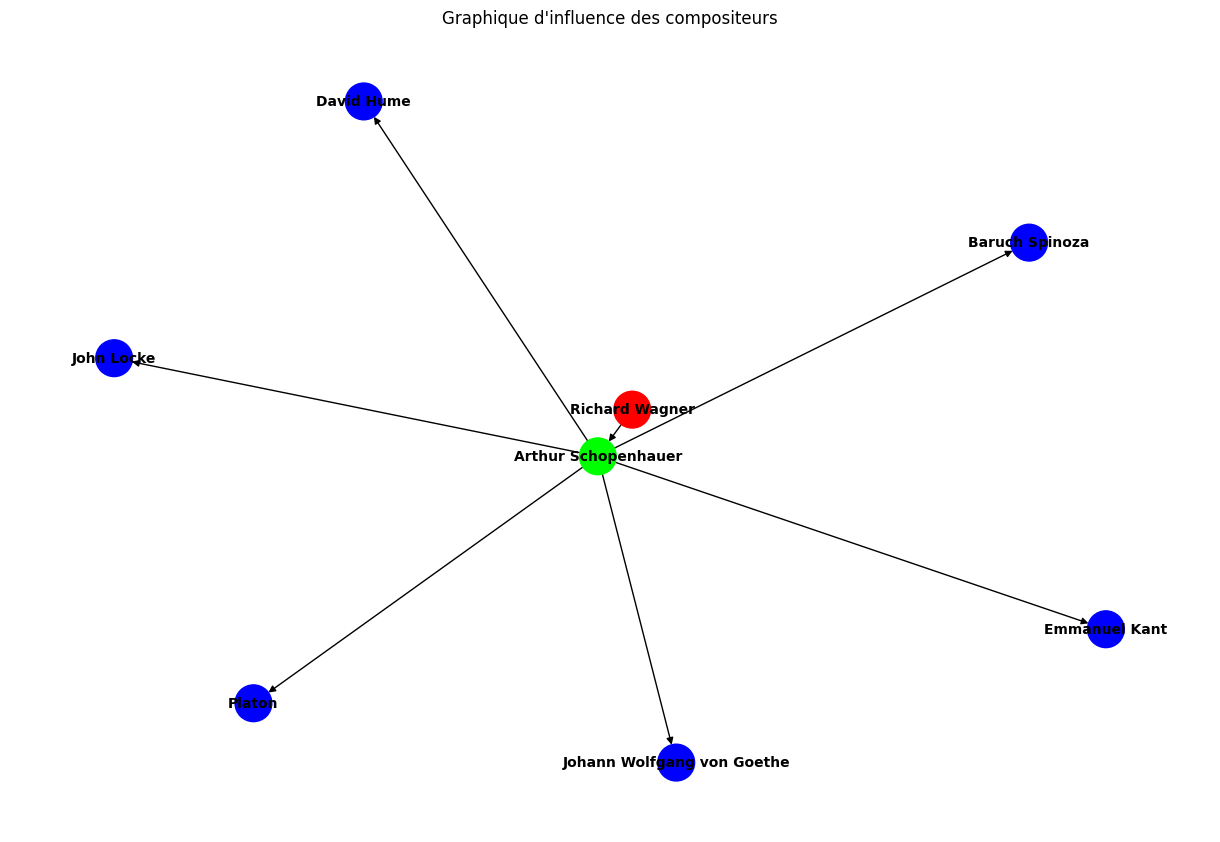

In [24]:
graph = graph_influence(find_id(("Richard","Wagner")), n_max_iter=2)

def draw_graph(graph):
    import matplotlib.pyplot as plt
    pos = nx.spring_layout(graph, seed=42)  # Positionnement des nœuds
    plt.figure(figsize=(12, 8))
    colors = [graph.nodes[n]['color'] for n in graph.nodes()]
    nx.draw(graph, pos, with_labels=True, labels = nx.get_node_attributes(graph, 'nom complet'), node_size=700, node_color=colors, font_size=10, font_weight="bold", arrows=True)
    plt.title("Graphique d'influence des compositeurs")
    plt.show()
draw_graph(graph)

## Graphe complet d'influences

In [ ]:
def graphes_toutes_influences(li_compos,verb = False):
    G = nx.DiGraph()
    i=1
    for compos in li_compos:
        verbose(f"Traitement {i}/{len(li_compos)} : {compos[0]} {compos[1]}",verb)
        i+=1
        id_compos = find_id(compos)
        if id_compos is not None:
            profile = find_all_properties(id_compos, dico_props=dico_props)
            G.add_node(id_compos)
            G.nodes[id_compos].update(profile)
            G.nodes[id_compos]["color"] = "red"
            if "influences" in profile and profile["influences"] is not None:
                for influ in profile["influences"]:
                    G.add_edge(id_compos,influ)
                    profile_influ = find_all_properties(influ, dico_props=dico_props)
                    G.nodes[influ].update(profile_influ)
                    if "color" not in G.nodes[influ] :
                        G.nodes[influ]["color"] = "blue"
    return G


In [ ]:
graph = graphes_toutes_influences(composers[:100], verb = True) #Environ 3 minutes pour 100 compositeurs

Traitement 1/100 :  Adolphe Adam
Traitement 2/100 :  Dionisio Aguado
Traitement 3/100 :  Julián Aguirre
Traitement 4/100 :  Isaac Albéniz
Traitement 5/100 :  Tomaso Albinoni
Traitement 6/100 :  Johann Georg Albrechtsberger
Traitement 7/100 :  Charles Valentin Alkan
Traitement 8/100 :  Gregorio Allegri
Traitement 9/100 :  William Alwyn
Traitement 10/100 :  Joachim Andersen
Traitement 11/100 :  Leroy Anderson
Traitement 12/100 :  Louis Andriessen
Traitement 13/100 :  Giovanni Animuccia
Traitement 14/100 :  Hans Erich Apostel
Traitement 15/100 :  Bert Appermont
Traitement 16/100 :  Jacob Arcadelt
Traitement 17/100 :  Anton Arensky
Traitement 18/100 :  Malcolm Arnold
Traitement 19/100 :  Samuel Arnold
Traitement 20/100 :  Juan Crisóstomo Arriaga
Traitement 21/100 :  Emilio Arrieta Corera
Traitement 22/100 :  Claude Arrieu
Traitement 23/100 :  Leo Ascher
Traitement 24/100 :  Daniel Asia
Traitement 25/100 :  Feike Asma
Traitement 26/100 :  Sergio Assad
Traitement 27/100 :  Pierre Attaingnant